## Experiments in improving segmentation performance for lung ultrasound (LSU):

An overview:

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In this nb, I try and use the training approach used in the [cat segmentation nb](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb).

In [1]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.7 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=510a6818ea1e35d8755384f82b405e7a29a46aa53061e1459058ae259c541aa2
  Stored in directory: /root/.cache/pip/wheels/22/16/f1/5369d23a06852d5f083d23a1addf0904575f1296f71b412ac8
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=2fb121bae83c36fe7338de23f02e40eb06b567457f77dbc0e660c9a76799ec9f
  Stored in directory: /root/.cache/pip/wheels/1f/9b/f5/9ccf39b50bc437986145107e2ced70a6fab622cf23e4795aa5
Successfully built effici

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

In [3]:
import pytorch_lightning as pl
print(pl.__version__)

1.5.4


In [41]:
# !pip install -U pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 39.9 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.5.4
    Uninstalling pytorch-lightning-1.5.4:
      Successfully uninstalled pytorch-lightning-1.5.4


## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [4]:
from PIL import Image
import os

In [5]:
with Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/origin/imgs/158-1_frame_0.jpg') as img:
        width, height= img.size
        
print(width, height)

960 720


Having a bunch of errors in trying to reshape the data to (3, 960, 720). First let's see what the data shape really is.

In [6]:
from PIL import Image
import torch
from torchvision import transforms

# Load the image
image = Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/origin/imgs/158-1_frame_0.jpg').convert('RGB')

# Define a transform to convert the image to tensor
transform = transforms.ToTensor()

# Apply the transform to the image
image_tensor = transform(image)

print(image_tensor.shape)  # Check the shape of the tensor

torch.Size([3, 720, 960])


Divisible by 32? 960 is, 720 is not - will have to add padding.

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        # Handle the image shape (3, 720, 960)
        if image.shape[0] == 3:
            image = image.transpose(1, 2, 0)  # Convert to (720, 960, 3)

        # Handle the mask shape (1, 720, 960)
        elif image.shape[0] == 1:
            image = np.squeeze(image, axis=0)  # Squeeze to (720, 960)

        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [11]:
import numpy as np

def pad_im(image):
    # Pad the image
    total_pad = 736 - 720
    pad_top = total_pad // 2
    pad_bottom = total_pad - pad_top
    padded_im = np.pad(image, ((0, 0), (pad_top, pad_bottom), (0, 0)), mode='constant')
    
    return padded_im

# def pad_mask(mask):
#     # Pad the image
#     total_pad = 736 - 720
#     pad_top = total_pad // 2
#     pad_bottom = total_pad - pad_top
#     padded_mask = np.pad(mask, ((0, 0), (pad_top, pad_bottom), (0, 0)), mode='constant')
    
#     return padded_mask

def convert_mask(mask):
    # Reshape mask from (720, 960, 3) to (3, 720, 960)
    # mask_reshaped = np.transpose(mask, (2, 0, 1))
    # Convert RGB to Grayscale
    # The weights (0.2989, 0.5870, 0.1140) are common for converting RGB to Grayscale
    # gray_mask = 0.2989 * mask[0] + 0.5870 * mask[1] + 0.1140 * mask[2]
    # summed_image = np.sum(mask, axis=0, keepdims=True)
    # summed_image = mask
    # threshold = 200
    # Apply threshold: values greater than the threshold become 1, others become 0
    # binary_image = np.where(summed_image > threshold, 1, 0)

    # msk_array = np.asarray(msk)
    norm_mask = mask / 255.0

    # Add an extra dimension to make it (1, 720, 960)
    # gray_mask = np.expand_dims(gray_mask, axis=0)
    mask_expanded = np.expand_dims(norm_mask, axis=0)
    
    return mask_expanded

# Example usage
# Assuming `original_mask` is your input mask with shape (720, 960, 3)

# converted_mask = convert_mask(original_mask)
# print("Converted mask shape:", converted_mask.shape)

### Quick Test of Operations

In [12]:
img = Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/origin/imgs/158-1_frame_0.jpg')
msk = Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/train/mask/163-2_frame_59.png')

msk_array = np.asarray(msk)

Actually just have to test the mask. The values have to be normalized to be within values 0 to 1.

In [13]:
print("Original pixel values:")
print(msk_array)

Original pixel values:
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


In [14]:
normalized_msk_array = msk_array / 255.0
print("Normalized pixel values:")
print(normalized_msk_array)

Normalized pixel values:
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [33]:
print(msk)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=960x720 at 0x7FABB02B8D30>


## Dataloader

In [15]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
#     CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
#                'tree', 'signsymbol', 'fence', 'car', 
#                'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.png')) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = pad_im(image)
        
        # image = convert_im(image)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = convert_mask(mask)
        mask = pad_im(mask)
        
        # print("Image data type:", type(image))
        # print("Image shape:", image.shape)
        # print("Mask shape:", mask.shape)
        
        # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')
        
            
        return {"image": image, "mask": mask}
        # return image, mask
        
    def __len__(self):
        return len(self.ids)

Let's try and see the data we have:

In [16]:
x_valid_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/image'
y_valid_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/mask'

x_test_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/image'
y_test_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/mask'

In [17]:
x_train_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/train/image'
y_train_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/train/mask'
dataset = Dataset(x_train_dir, y_train_dir)
# print(dataset)

In [18]:
dataset[1]["image"]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

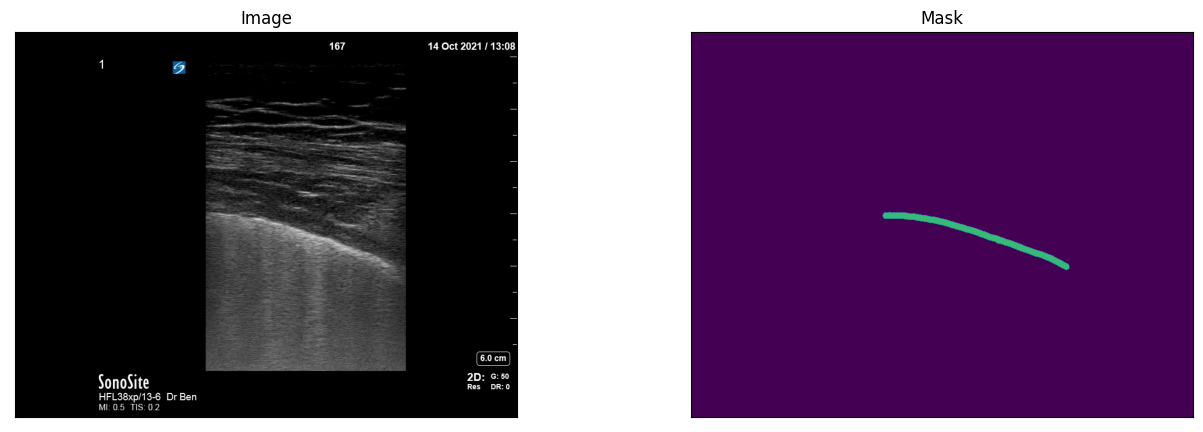

In [19]:
image, mask = dataset[1] # get some sample
visualize(
    image=dataset[1]["image"], 
    mask=dataset[1]["mask"],
)

In [29]:
mask=dataset[1]["mask"]
max(mask), mask.size

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 706560)

Okay, thankfully the data frickin works! But I think the mask is inverted - which shouldn't be a tough fix. Now let's give this a shot. Can also add data augmentations based on this [nb](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb).

In [30]:
import torch
from torch import tensor
import pandas as pd

In [31]:
msk=dataset[1]["mask"]
msk_t = tensor(msk)
# df = pd.DataFrame(mask[4:15,4:22])
df = pd.DataFrame(mask.squeeze()[480:500, 500:550])
print(df.shape)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

(20, 50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [41]:
mask = cv2.imread('/notebooks/pleural_line_segment/init_play/baby_dataset/train/mask/165-2_frame_119.png', 0)
# mask = convert_mask(mask)

In [42]:
mask_inv = 255 - mask

In [43]:
mask_inv.shape

(720, 960)

In [44]:
mask_inv = mask_inv / 255.0

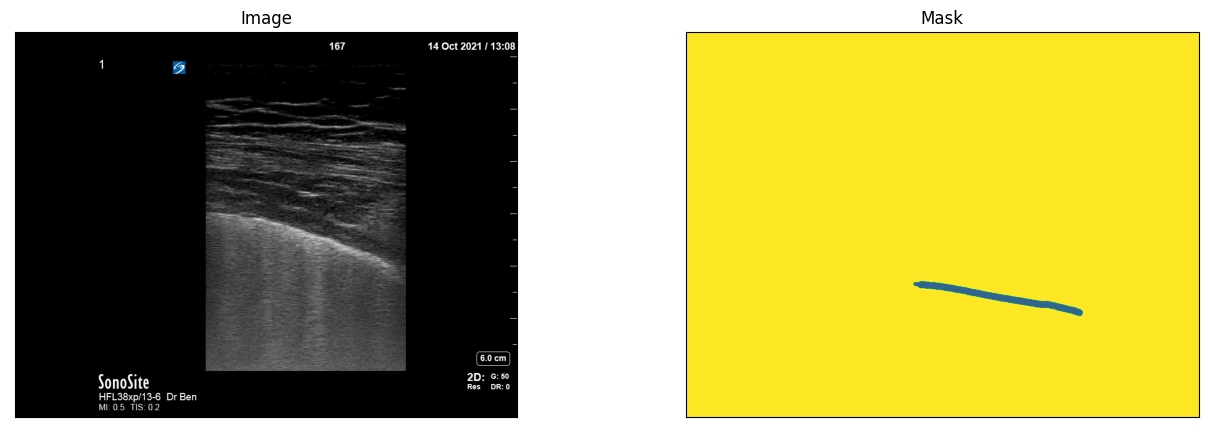

In [45]:
image, mask = dataset[1] # get some sample
visualize(
    image=dataset[1]["image"], 
    mask=mask_inv,
)

In [40]:
msk = mask_inv
msk_t = tensor(msk)
# df = pd.DataFrame(mask[4:15,4:22])
df = pd.DataFrame(msk_t.squeeze()[470:490, 500:550])
print(df.shape)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

(20, 50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.611765,0.615686,0.600000,0.623529,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.611765,0.611765,0.611765,0.615686,0.611765,0.611765,0.615686,0.588235,0.584314,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.611765,0.611765,0.611765,0.611765,0.611765,0.615686,0.615686,0.611765,0.611765,0.611765,0.615686,0.615686,0.615686,0.615686,0.623529,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.615686,0.611765,0.615686,0.611765,0.611765,0.603922,0.615686,0.623529,0.615686,0.615686,0.611765,0.623529,0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.615686,0.611765,0.615686,0.615686,0.611765,0.611765,0.611765,0.611765,0.611765,0.611765,0.603922,0.603922,0.615686,0.635294,0.66666

In [20]:
def convert_mask(mask):
  
    # mask_inv = 255 - mask
    norm_mask = mask / 255.0

    # Add an extra dimension to make it (1, 720, 960)
    # gray_mask = np.expand_dims(gray_mask, axis=0)
    mask_expanded = np.expand_dims(norm_mask, axis=0)
    
    return mask_expanded

# Example usage
# Assuming `original_mask` is your input mask with shape (720, 960, 3)

# converted_mask = convert_mask(original_mask)
# print("Converted mask shape:", converted_mask.shape)

In [25]:
#updated Dataset with mask processing
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        # self.ids = os.listdir(images_dir)
        self.ids = [file for file in os.listdir(images_dir) if file.endswith(('.jpg', '.png', '.jpeg')) and not file.startswith('.')]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.png')) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Unable to load image at {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = pad_im(image)
        
        # image = convert_im(image)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = convert_mask(mask)
        mask = pad_im(mask)
            
        return {"image": image, "mask": mask}

    def __len__(self):
        return len(self.ids)

In [109]:
# from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [110]:
# download data
# root = "."
# SimpleOxfordPetDataset.download(root)

In [111]:
# init train, val, test sets
# train_dataset = SimpleOxfordPetDataset(root, "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
# assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

# print(f"Train size: {len(train_dataset)}")
# print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

# # n_cpu = os.cpu_count()
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=n_cpu)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)

In [26]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir
    # augmentation=get_training_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [27]:
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 8
Valid size: 1
Test size: 1


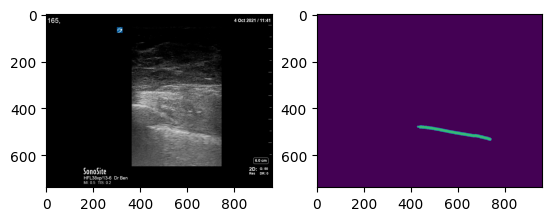

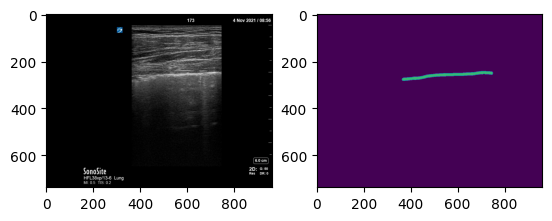

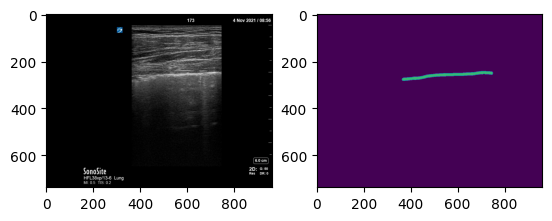

In [28]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [99]:
import torch

# Check if CUDA (GPU support) is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Then use the device for your tensors and models
# Example:
# model.to(device)
# x, y = x.to(device), y.to(device)

## Model

In [33]:
class Model(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [34]:
model = Model("FPN", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [42]:
# for x, y in train_loader:
#     # Convert inputs to float and optionally normalize
#     x = x.float() / 255.0  # Normalize to 0-1 if your data is in 0-255 range

#     x, y = x.to(device), y.to(device)
    
# for x, y in valid_loader:
#     # Convert inputs to float and optionally normalize
#     x = x.float() / 255.0  # Normalize to 0-1 if your data is in 0-255 range

#     x, y = x.to(device), y.to(device)
    
# for x, y in test_loader:
#     # Convert inputs to float and optionally normalize
#     x = x.float() / 255.0  # Normalize to 0-1 if your data is in 0-255 range

#     x, y = x.to(device), y.to(device)

In [25]:
# model = Model("FPN", "resnet34", in_channels=3, out_classes=1)

## Training

In [31]:
print(model)

Model(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

In [32]:
print(train_loader)

In [33]:
print(valid_loader)

In [39]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=3,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [54]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=6,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Validation and test metrics

In [40]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.0, 'valid_per_image_iou': 0.0}]


In [41]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.0, 'test_per_image_iou': 0.0}]


# Result visualization

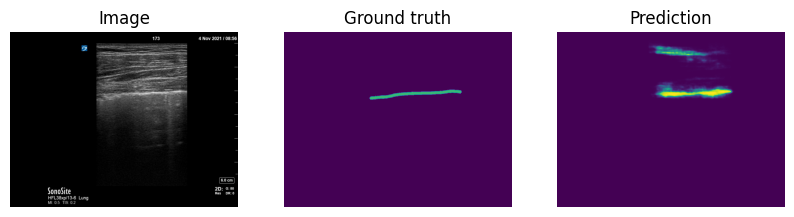

In [42]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

Alright, idk how that worked, but the model literally learned from 8 frames, and is able to infer a pretty good mask (which I think is even better than my 'ground truth'!). So - now going to run inference on all the 180 frames from the 173_1 video, and see how it does.

How? Create a new folder with the 180 frames of said video, create a `test_loader` and run inference. Then concatenate the results somehow and create a video. 

In [37]:
#load the model that unexpectedly worked (on 8 images)
checkpoint_path = "/notebooks/pleural_line_segment/init_play/repos/segmentation_models.pytorch/lightning_logs/version_15/checkpoints/epoch=5-step=47.ckpt"

In [38]:
model = model.load_from_checkpoint(checkpoint_path)

TypeError: __init__() missing 4 required positional arguments: 'arch', 'encoder_name', 'in_channels', and 'out_classes'

loading from chkpoint doesn't seem to work, can figure it out later!!

In [43]:
#updated Dataset with mask processing
class InfDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            images_dir,
            augmentation=None, 
            preprocessing=None,
    ):
        # self.ids = os.listdir(images_dir)
        self.ids = [file for file in os.listdir(images_dir) if file.endswith(('.jpg', '.png', '.jpeg')) and not file.startswith('.')]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.png')) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Unable to load image at {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = pad_im(image)
        
        # # image = convert_im(image)
        # mask = cv2.imread(self.masks_fps[i], 0)
        # mask = convert_mask(mask)
        # mask = pad_im(mask)
            
        # return {"image": image}
        return {"image": image, "mask": mask}

    def __len__(self):
        return len(self.ids)

In [44]:
x_inf_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/image'
y_inf_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/mask'

In [45]:
# inf_dataset = InfDataset(
inf_dataset = Dataset(
    x_inf_dir, 
    y_inf_dir
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

In [46]:
inference_loader = DataLoader(inf_dataset, batch_size=1, shuffle=False, num_workers=4)

Let's try running inference:

In [116]:
# run test dataset
inf_metrics = trainer.test(model, dataloaders=inference_loader, verbose=False)
pprint(inf_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 1.1526870366651565e-05,
  'test_per_image_iou': 1.1857524441438727e-05}]


Okay so, I can use my own simplifed code to run inference (and load checkpoint). But for now lemme try with the code that's here (no mask? just add the og images in mask folder).

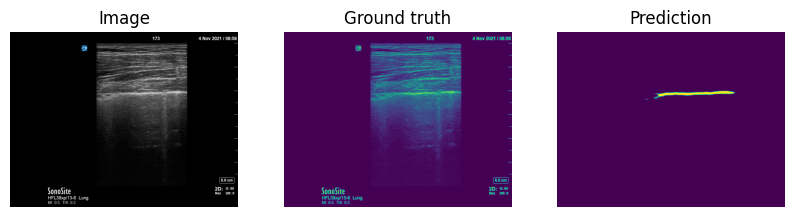

In [117]:
# batch = next(iter(inference_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

model.eval()
        logits = model(batch["image"])
    plt.show()

Aight let's test something.

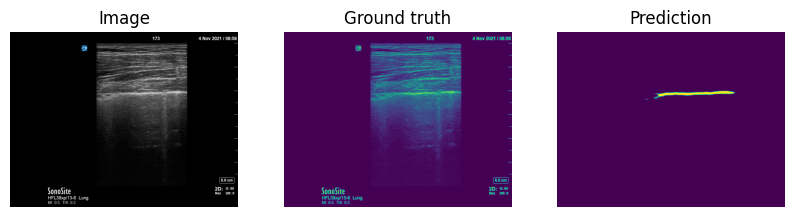

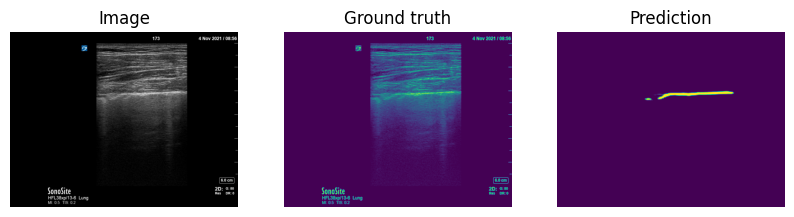

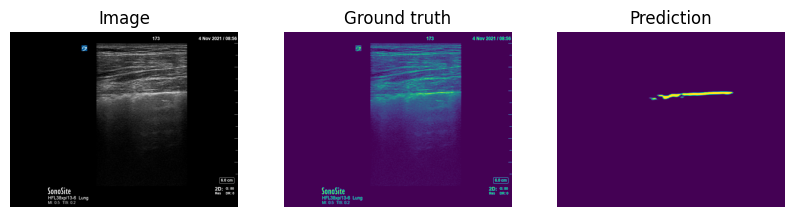

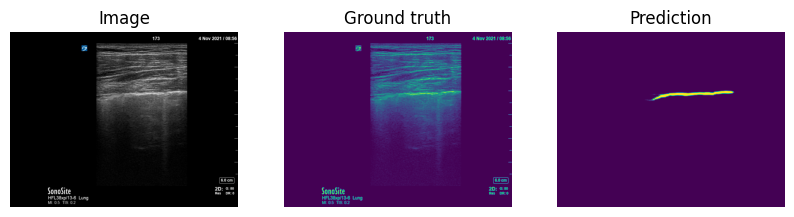

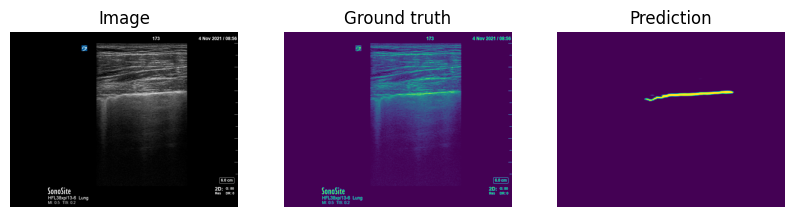

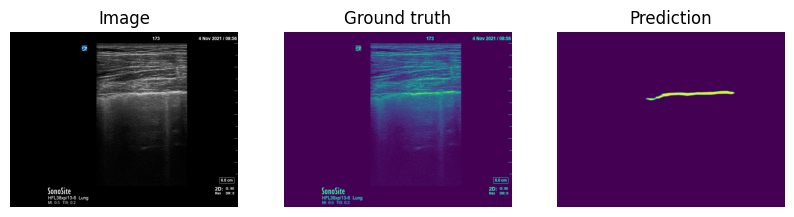

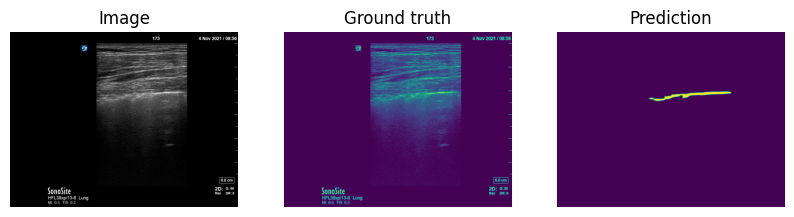

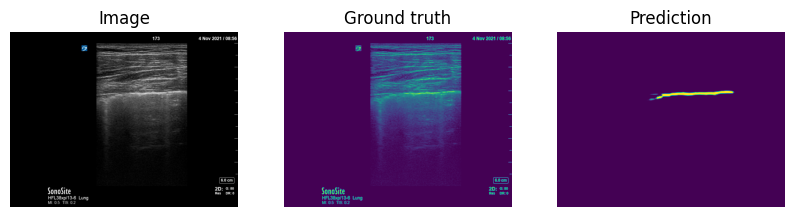

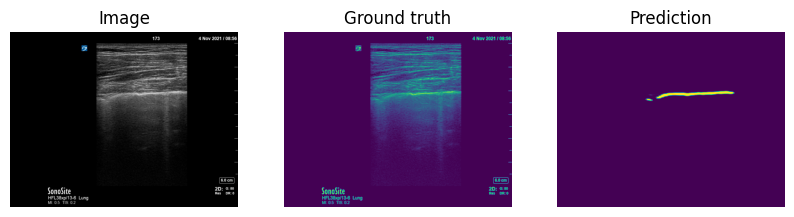

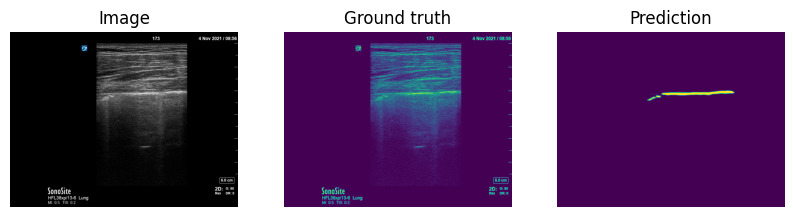

In [ ]:
# batch = next(iter(inference_loader))
import matplotlib.pyplot as plt
import torch

# Assuming inference_loader is defined and model is loaded

model.eval()  # Set the model to evaluation mode
num_images_displayed = 0  # Counter for displayed images

for batch in inference_loader:
    with torch.no_grad():
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

        num_images_displayed += 1
        if num_images_displayed >= 10:
            break

    if num_images_displayed >= 10:
        break

Alright, perfect, that worked too. Now let's try making a video

In [121]:
from tqdm import tqdm

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask(image, mask, alpha=0.5):
    # Apply a colormap to the mask
    colored_mask = cv2.applyColorMap((mask * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Overlay the mask on the image
    overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

    return overlay

# Assuming model and inference_loader are defined and ready
model.eval()
overlaid_images = []

for batch in tqdm(inference_loader, desc="Processing images", total=180):
    with torch.no_grad():
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, pr_mask in zip(batch["image"], pr_masks):
        # Convert image and mask to numpy format
        np_image = image.numpy().transpose(1, 2, 0)
        np_image = (np_image * 255).astype(np.uint8)  # assuming image was normalized
        np_mask = pr_mask.numpy().squeeze()

        # Overlay mask on image
        overlaid_image = overlay_mask(np_image, np_mask)
        overlaid_images.append(overlaid_image)

        if len(overlaid_images) >= 180:
            break

    if len(overlaid_images) >= 180:
        break


Processing images:  99%|█████████▉| 179/180 [04:28<00:01,  1.50s/it]


In [123]:
video_name = 'overlaid_video_173-1.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()


Processing video: 100%|██████████| 180/180 [00:01<00:00, 144.04it/s]


Here's how a frame from the video looks rn:  
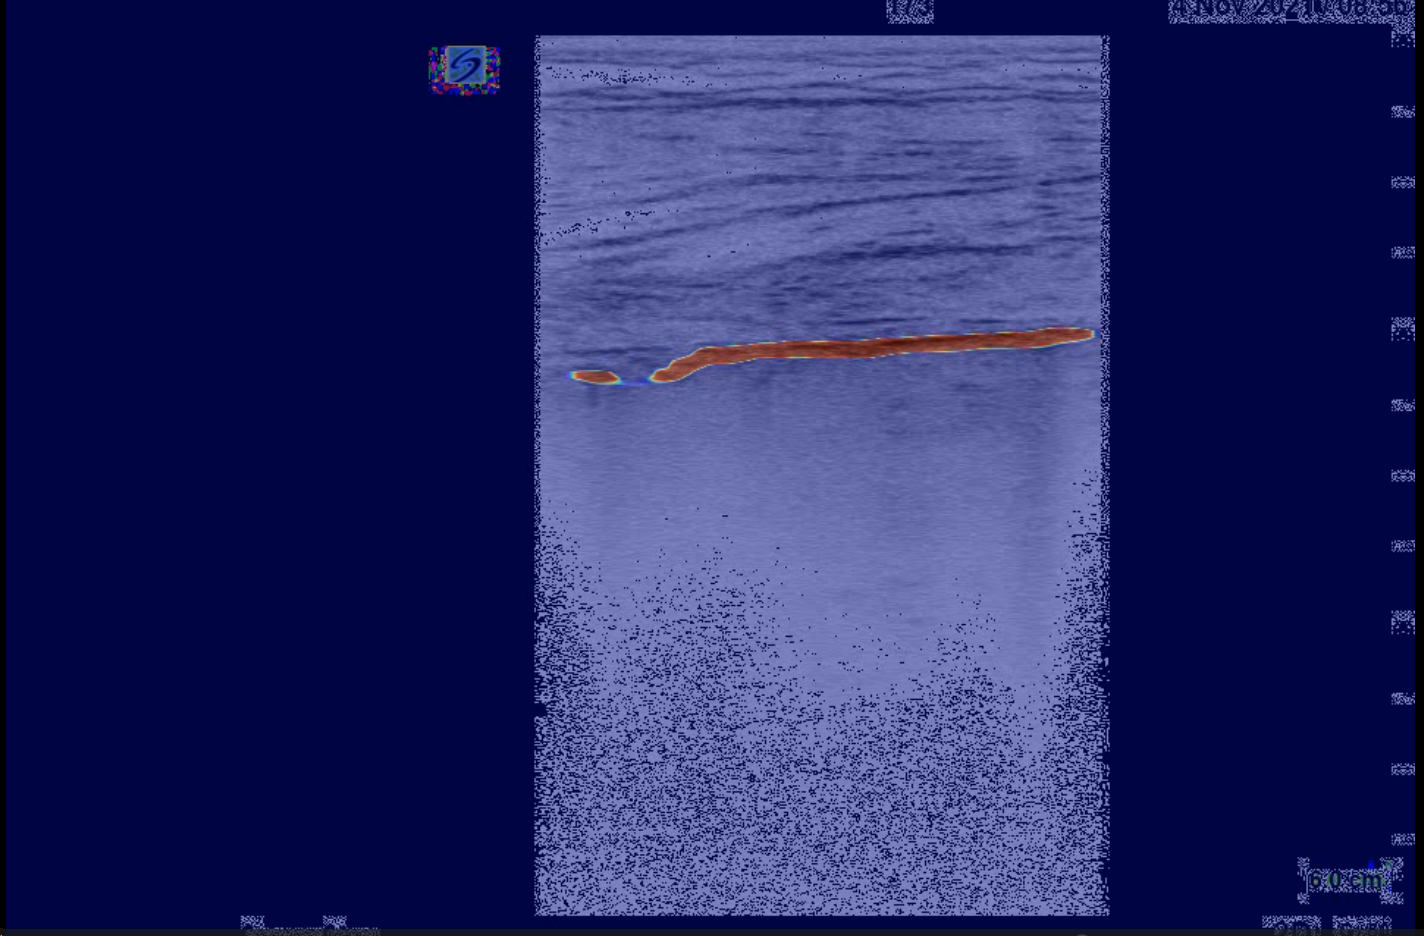

Just gotta dig a little deeper into how the mask would look added to the video, how to adjust coloring to make it sit well on top of the original video, and then execute. 